In [114]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import os.path
import h5py
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')
import pandas as pd
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

from tensorflow.keras.layers.experimental import preprocessing

from hera_sim import foregrounds, noise, sigchain, rfi, simulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2.4.0


# Generate visibility plot

In [218]:
'''
Generate one visibility
'''
def generate_one_vis(lsts, fqs, bl_len_ns):
    # point-source and diffuse foregrounds
    vis = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)
    Tsky_mdl = noise.HERA_Tsky_mdl['xx']
    vis += foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl)

    # noise
#     tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
#     t_rx = 150.
#     OMEGA_P = (0.72)*np.ones(1024)
#     nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
#     vis += nos_jy
    
    # crosstalk, gains
    xtalk = sigchain.gen_whitenoise_xtalk(fqs)
    g = sigchain.gen_gains(fqs, [1,2,3])
    vis = sigchain.apply_xtalk(vis, xtalk)
    vis = sigchain.apply_gains(vis, g, (1,2))

    return vis[:, :, np.newaxis]

'''
Plot one visibility
MX is max value of color scale in the plot
DRNG = MX - min value of color scale in the plot
'''
def plot_one_vis(vis, ylim, MX, DRNG, figsize):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
      
    fig.sca(ax1)
    uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG)
    plt.colorbar(label=r"Amplitude [log$_{10}$(V/Jy)]")
    plt.ylim(0,ylim)

    fig.sca(ax2)
    uvtools.plot.waterfall(vis, mode='phs')
    plt.colorbar(label="Phase [rad]")
    plt.ylim(0,ylim)
    plt.xlabel("Frequency channel")

    fig.text(0.02, 0.5, 'LST [rad]', ha='center', va='center', rotation='vertical')

'''
Generate n visibilities
'''
def generate_vis(n, lsts, fqs, bl_len_ns):
    res = []
    for i in range(n):
        res.append(generate_one_vis(lsts, fqs, bl_len_ns))
    return np.array(res)

<class 'numpy.ndarray'>
(1500, 1024, 1)


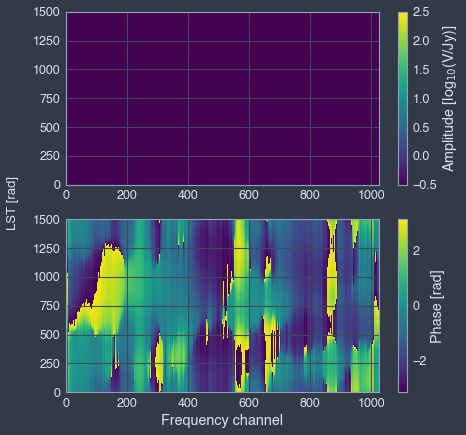

In [219]:
lsts = np.linspace(1, 0.5*np.pi, 1500, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
# 1500 to match the mask; π/2 ~ 6h
fqs = np.linspace(.1, .2, 1024, endpoint=False) # frequencies in GHz; start freq, end freq, number of channels
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

vis = generate_one_vis(lsts, fqs, bl_len_ns)
print(type(vis))
print(vis.shape)
plot_one_vis(vis[:,:,0], 1500, 2.5, 3, (7,7))

# RFI mask
This is a boolean mask: `True` = RFI, `False` = no RFI

Parameters:
- 6 hours in JD, 1500 units
  - times match: using range π/2 for lsts in vis plot, with 1500 snapshots
- 1024 channels, 100-200 MHz

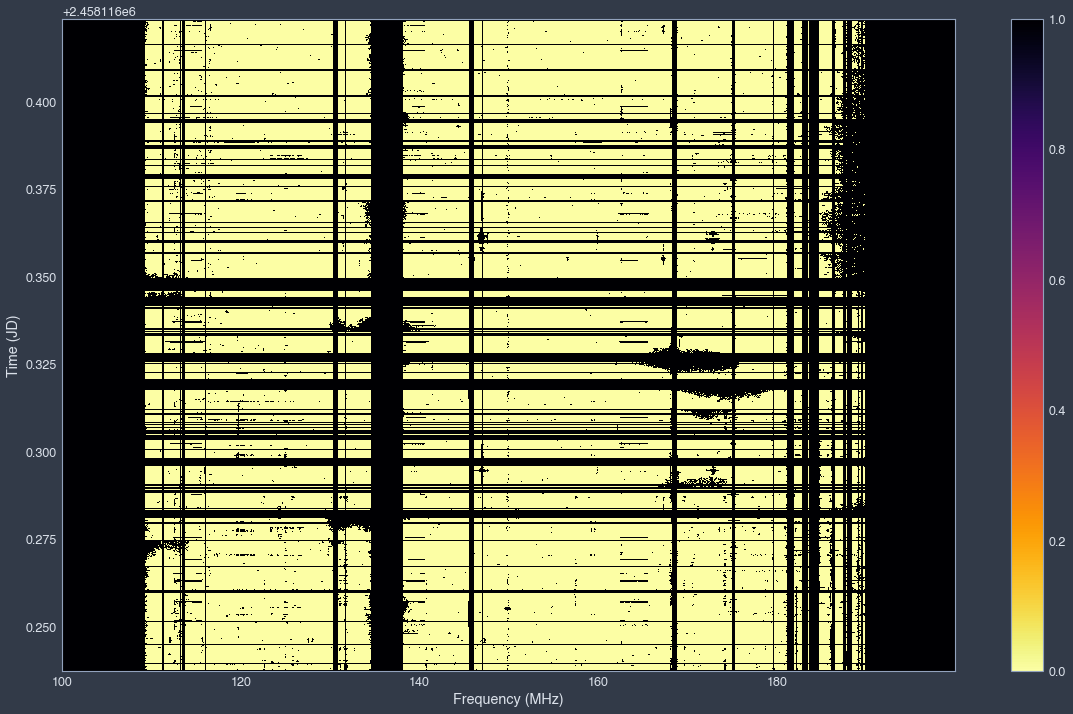

(1500, 1024)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [79]:
f = h5py.File("mask_HERA.hdf5", "r")
plt.figure(figsize=(20,12))
mask = f['mask']
plt.imshow((mask[()]), cmap='inferno_r', aspect='auto',
           origin='lower', vmin=0, vmax=1,
           extent=(f['axes']['frequency'][0]/1e6,f['axes']['frequency'][-1]/1e6,
                  f['axes']['time'][0], f['axes']['time'][-1]))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (JD)')
plt.grid()
plt.colorbar()
plt.show()
print(mask.shape)
print(mask[()])

### Generate custom masks

Take horizontal or vertical pixel slice of the mask. Spans of the `True` sections = spans of RFI

In [54]:
'''
Get RFI spans from one row/col
'''
def get_RFI_spans(row):
    spans = [(key, sum(1 for _ in group)) for key, group in itertools.groupby(row)]
    ############## ask Adrian ##############
#     spans = spans[1:-1] # remove first and last element of mask? 
    if len(spans) == 1:
        raise Exception("Error: all values in the row/col are True; select another one")
    return spans

rfi_widths = get_RFI_spans(mask[1434])
rfi_heights = get_RFI_spans(mask[:,166])

# print("RFI widths", rfi_widths)
# print("RFI heights", rfi_heights)

Generate randomized mask from spans

In [129]:
def plot_mask(mask, mask2, mask3):
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.grid(False)
    plt.imshow(mask, cmap='inferno_r') # black is RFI
    plt.subplot(1, 3, 2)
    plt.grid(False)
    plt.imshow(mask2, cmap='inferno_r')
    plt.subplot(1, 3, 3)
    plt.grid(False)
    plt.imshow(mask3, cmap='inferno_r')

'''
Generate random RFI mask with dimensions time x freq, given RFI spans from a real mask
'''
def generate_one_mask(time, freq, widths, heights, plot=False):
    random.shuffle(widths)
    random.shuffle(heights)
    
    # row by row
    one_row = []
    for w in widths:
        one_row.extend([w[0]] * w[1])
    mask = np.tile(one_row, (time, 1)) # copy one_row `time` times in the vertical direction
#     print(mask.shape)
#     print(widths)
    
    # col by col
    one_col = []
    for w in heights:
        one_col.extend([w[0]] * w[1])
    mask2 = np.tile(np.array(one_col).reshape((time, 1)), (1, freq))
#     print(mask2.shape)
    
    combined_mask = np.logical_or(mask, mask2) # any cell with True will have RFI
    if plot:
        plot_mask(mask, mask2, combined_mask)
    return combined_mask

'''
Generate n masks
'''
def generate_masks(n, time, freq, widths, heights):
    res = []
    for i in range(n):
        res.append(generate_one_mask(time, freq, widths, heights))
    return np.array(res)


[[False False False ...  True  True False]
 [False False False ...  True  True False]
 [False False False ...  True  True False]
 ...
 [False False False ...  True  True False]
 [False False False ...  True  True False]
 [False False False ...  True  True False]]


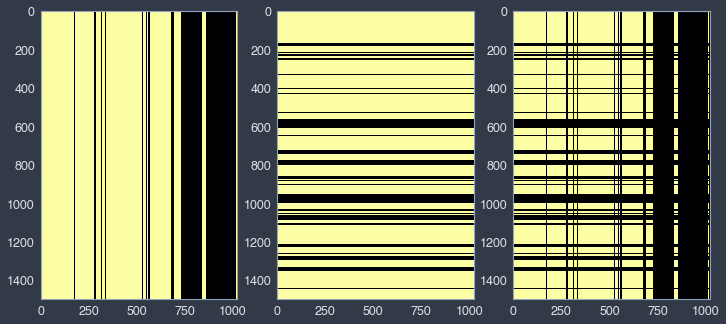

In [126]:
custom_mask = generate_one_mask(1500, 1024, rfi_widths, rfi_heights, plot=True)
print(custom_mask)

### Apply mask to visibility

In [112]:
vis[custom_mask == False] = 0
print(vis.shape)

(1500, 1024)


# Create dataset

Create visibilities and masks

In [220]:
lsts = np.linspace(1, 0.5*np.pi, 1500, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
# 1500 to match the mask; π/2 ~ 6h
fqs = np.linspace(.1, .2, 1024, endpoint=False) # frequencies in GHz; start freq, end freq, number of channels
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

vis = generate_vis(10, lsts, fqs, bl_len_ns)
mask = generate_one_mask(1500, 1024, rfi_widths, rfi_heights)

Create data and labels

In [221]:
data = vis.copy()
for i, v in enumerate(data):
    v[mask == False] = 0
# print(np.count_nonzero(train_dataset[0]==0)) # check number of 0's in a given vis (to check if mask worked)

labels = vis

Separate train and test sets

In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6, 1500, 1024, 1) (4, 1500, 1024, 1) (6, 1500, 1024, 1) (4, 1500, 1024, 1)


# ML model

In [228]:
def build_and_compile_model():
  model = keras.Sequential([
#       layers.Dense(1024, activation='relu', input_shape=(1500, 1024)),
      layers.Conv2D(64, kernel_size=1, activation='relu', input_shape=(1500,1024,1)),
      layers.Conv2D(32, kernel_size=1, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae','acc'])
  return model

In [230]:
model = build_and_compile_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1500, 1024, 64)    128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1500, 1024, 32)    2080      
_________________________________________________________________
dense_39 (Dense)             (None, 1500, 1024, 1)     33        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [231]:
%%time
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=5)

Epoch 1/5
1/1 [==============================] - 19s 19s/step - loss: 0.0234 - mae: 0.0234 - acc: 0.0000e+00 - val_loss: 0.0193 - val_mae: 0.0193 - val_acc: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 17s 17s/step - loss: 0.0210 - mae: 0.0210 - acc: 0.0000e+00 - val_loss: 0.0183 - val_mae: 0.0183 - val_acc: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 14s 14s/step - loss: 0.0200 - mae: 0.0200 - acc: 0.0000e+00 - val_loss: 0.0167 - val_mae: 0.0167 - val_acc: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 18s 18s/step - loss: 0.0183 - mae: 0.0183 - acc: 0.0000e+00 - val_loss: 0.0163 - val_mae: 0.0163 - val_acc: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 15s 15s/step - loss: 0.0178 - mae: 0.0178 - acc: 0.0000e+00 - val_loss: 0.0151 - val_mae: 0.0151 - val_acc: 0.0000e+00
CPU times: user 59.6 s, sys: 1min 6s, total: 2min 5s
Wall time: 1min 22s


In [232]:
preds = model.predict(X_train)
preds

array([[[[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        ...,

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]],

        [[0.00190838],
         [0.00190838],
         [0.00190838],
         ...,
         [0.00190838],
         [0.00190838],
         [0.00190838]]],


       [[[0.00190838],
         [0.00190838],
         [0.00

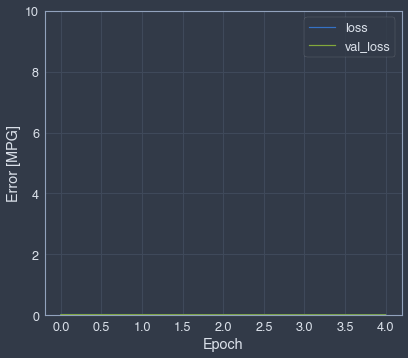

In [233]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
f.close()